Using device: cuda


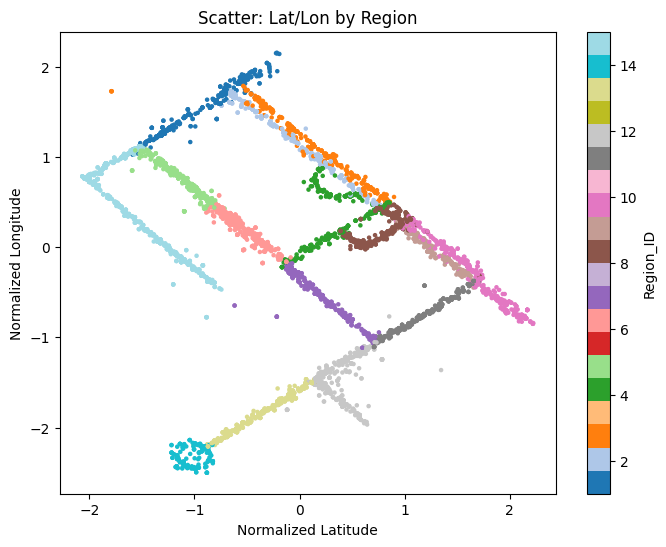

/tmp/ipykernel_31/1787430124.py:159: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1 Training:   0%|          | 0/203 [00:00<?, ?it/s]/tmp/ipykernel_31/1787430124.py:174: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 Validation: 100%|██████████| 12/12 [00:02<00:00,  4.22it/s]


Epoch 1: MSE_lat=240667.3750, MSE_lon=342015.0625, Avg=291341.2188
Ensemble up to epoch 1: MSE_lat=240667.3750, MSE_lon=342015.0625, Avg=291341.2188


Epoch 2 Training:   0%|          | 0/203 [00:00<?, ?it/s]/tmp/ipykernel_31/1787430124.py:174: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 Validation: 100%|██████████| 12/12 [00:02<00:00,  4.24it/s]


Epoch 2: MSE_lat=164767.7812, MSE_lon=225043.4062, Avg=194905.5938
Ensemble up to epoch 2: MSE_lat=187148.8906, MSE_lon=228411.3438, Avg=207780.1250


Epoch 3 Training:   0%|          | 0/203 [00:00<?, ?it/s]/tmp/ipykernel_31/1787430124.py:174: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 Validation: 100%|██████████| 12/12 [00:02<00:00,  4.25it/s]


Epoch 3: MSE_lat=106976.1328, MSE_lon=171688.6562, Avg=139332.3906
Ensemble up to epoch 3: MSE_lat=142715.4219, MSE_lon=190249.9375, Avg=166482.6875


Epoch 4 Training:   0%|          | 0/203 [00:00<?, ?it/s]/tmp/ipykernel_31/1787430124.py:174: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 Validation: 100%|██████████| 12/12 [00:02<00:00,  4.23it/s]


Epoch 4: MSE_lat=92565.5859, MSE_lon=168370.9375, Avg=130468.2656
Ensemble up to epoch 4: MSE_lat=115563.9219, MSE_lon=168986.5469, Avg=142275.2344


Epoch 5 Training:   0%|          | 0/203 [00:00<?, ?it/s]/tmp/ipykernel_31/1787430124.py:174: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 Validation: 100%|██████████| 12/12 [00:02<00:00,  4.26it/s]


Epoch 5: MSE_lat=99509.9453, MSE_lon=136231.2969, Avg=117870.6250
Ensemble up to epoch 5: MSE_lat=102283.6562, MSE_lon=152482.0781, Avg=127382.8672


Epoch 6 Training:   0%|          | 0/203 [00:00<?, ?it/s]/tmp/ipykernel_31/1787430124.py:174: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 Validation: 100%|██████████| 12/12 [00:02<00:00,  4.20it/s]


Epoch 6: MSE_lat=84892.9922, MSE_lon=107694.0312, Avg=96293.5156
Ensemble up to epoch 6: MSE_lat=91302.5391, MSE_lon=139009.3906, Avg=115155.9688


Epoch 7 Training:   0%|          | 0/203 [00:00<?, ?it/s]/tmp/ipykernel_31/1787430124.py:174: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 Validation: 100%|██████████| 12/12 [00:02<00:00,  4.22it/s]


Epoch 7: MSE_lat=62430.1367, MSE_lon=96943.1797, Avg=79686.6562
Ensemble up to epoch 7: MSE_lat=83533.0078, MSE_lon=128572.5938, Avg=106052.7969


Epoch 8 Training:   0%|          | 0/203 [00:00<?, ?it/s]/tmp/ipykernel_31/1787430124.py:174: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 Training:   8%|▊         | 16/203 [00:10<02:01,  1.54it/s]

In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timm
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Utility: extract numeric ID from filename
def extract_image_id(filename):
    return int(os.path.splitext(filename)[0].split('_')[-1])

# Timestamp parser for HH:MM or HH:MM:SS formats
def parse_timestamp(timestamp_str):
    if pd.isna(timestamp_str):
        return 0.0
    parts = str(timestamp_str).split(':')
    try:
        if len(parts) == 2:
            h, m = map(float, parts)
            return h * 60 + m
        elif len(parts) == 3:
            h, m, s = map(float, parts)
            return h * 60 + m + s / 60
    except ValueError:
        return 0.0
    return 0.0

# Load CSVs
train_csv = "/kaggle/input/smainewdataset/Phase_2_data/labels_train.csv"
val_csv   = "/kaggle/input/smainewdataset/Phase_2_data/labels_val.csv"
train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)

# Filter training outliers (latitude 200k–230k, longitude 140k–150k)
train_df = train_df[train_df['latitude'].between(200000, 230000) &
                    train_df['longitude'].between(140000, 150000)].reset_index(drop=True)

# Exclude specific image IDs from validation
exclude_ids = {95, 145, 146, 158, 159, 160, 161}
val_df = val_df[~val_df['filename'].apply(lambda x: extract_image_id(x) in exclude_ids)].reset_index(drop=True)

# Scatter plot of normalized lat/lon by Region_ID
scaler = StandardScaler()
scaled = scaler.fit_transform(train_df[['latitude','longitude']])
plt.figure(figsize=(8,6))
plt.scatter(scaled[:,0], scaled[:,1], c=train_df['Region_ID'], cmap='tab20', s=5)
plt.xlabel('Normalized Latitude')
plt.ylabel('Normalized Longitude')
plt.title('Scatter: Lat/Lon by Region')
plt.colorbar(label='Region_ID')
plt.show()

# Build meta features (time and placeholders for cyclic features)
def build_meta(df):
    df['time_minutes'] = df['timestamp'].apply(parse_timestamp)
    df['weekday_sin'] = 0.0
    df['weekday_cos'] = 0.0
    df['month_sin']   = 0.0
    df['month_cos']   = 0.0
    return df

class MultimodalLatLonDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = build_meta(df.copy()).reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

        # Scale features and targets
        self.feat_scaler = StandardScaler()
        self.df['time_minutes'] = self.feat_scaler.fit_transform(self.df[['time_minutes']])
        self.target_scaler = StandardScaler()
        self.df[['latitude','longitude']] = self.target_scaler.fit_transform(self.df[['latitude','longitude']])

        # Meta feature list
        self.meta_feats = ['time_minutes','Region_ID','weekday_sin','weekday_cos','month_sin','month_cos']

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Load image
        img = Image.open(os.path.join(self.img_dir, row['filename'])).convert('RGB')
        img = self.transform(img) if self.transform else transforms.ToTensor()(img)
        # Meta tensor
        meta = torch.tensor([row[f] for f in self.meta_feats], dtype=torch.float32)
        # Target tensor
        target = torch.tensor([row['latitude'], row['longitude']], dtype=torch.float32)
        return img, meta, target, row['filename']

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# DataLoaders
train_ds = MultimodalLatLonDataset(train_df, "/kaggle/input/smainewdataset/Phase_2_data/images_train/images_train", train_transform)
val_ds   = MultimodalLatLonDataset(val_df,   "/kaggle/input/smainewdataset/Phase_2_data/images_val/images_val",   val_transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Model definition
class MultimodalLatLonPredictor(nn.Module):
    def __init__(self, metadata_dim=6):
        super().__init__()
        # Swin Transformer backbone
        self.img_enc = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=0)
        feat_dim = self.img_enc.num_features
        # Meta network
        self.meta_enc = nn.Sequential(
            nn.Linear(metadata_dim,128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128,256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.5)
        )
        # Head
        self.head = nn.Sequential(
            nn.Linear(feat_dim+256,512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512,2)
        )

    def forward(self, x_img, x_meta):
        f_img  = self.img_enc(x_img)
        f_meta = self.meta_enc(x_meta)
        return self.head(torch.cat([f_img, f_meta], dim=1))

# Instantiate model, criterion, optimizer, scheduler, AMP scaler
model = MultimodalLatLonPredictor().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
scaler = torch.cuda.amp.GradScaler()

# Set up tracking variables
best_epoch_mse = float('inf')
best_epoch = -1
best_ensemble_mse = float('inf')
ensemble_preds = {fn: [] for fn in val_ds.df['filename']}

# Training loop
for epoch in range(1, 51):
    # Training
    model.train()
    for imgs, metas, targets, _ in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        imgs, metas, targets = imgs.to(device), metas.to(device), targets.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            preds = model(imgs, metas)
            loss = criterion(preds, targets)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
    scheduler.step()

    # Validation
    model.eval()
    all_preds, all_trues, all_fns = [], [], []
    with torch.no_grad():
        for imgs, metas, targets, fns in tqdm(val_loader, desc=f"Epoch {epoch} Validation"):
            imgs, metas = imgs.to(device), metas.to(device)
            preds = model(imgs, metas).cpu().numpy()
            all_preds.append(preds)
            all_trues.append(targets.numpy())
            all_fns.extend(fns)
    preds_np = np.vstack(all_preds)
    trues_np = np.vstack(all_trues)
    # Inverse scale
    inv_preds = train_ds.target_scaler.inverse_transform(preds_np)
    inv_trues = train_ds.target_scaler.inverse_transform(trues_np)

    # Compute metrics
    mse_lat = np.mean((inv_preds[:,0] - inv_trues[:,0])**2)
    mse_lon = np.mean((inv_preds[:,1] - inv_trues[:,1])**2)
    avg_mse = 0.5 * (mse_lat + mse_lon)
    print(f"Epoch {epoch}: MSE_lat={mse_lat:.4f}, MSE_lon={mse_lon:.4f}, Avg={avg_mse:.4f}")

    # Save best epoch model and predictions
    if avg_mse < best_epoch_mse:
        best_epoch_mse = avg_mse
        best_epoch = epoch
        # Save CSV
        df_out = pd.DataFrame({'filename': all_fns,
                               'pred_lat': inv_preds[:,0], 'pred_lon': inv_preds[:,1],
                               'true_lat': inv_trues[:,0], 'true_lon': inv_trues[:,1]})
        fname = f"predictions_{avg_mse:.4f}.csv"
        df_out.to_csv(fname, index=False)
        # Save model
        torch.save(model.state_dict(), f"best_model_epoch{epoch}_{avg_mse:.4f}.pth")

    # Update ensemble predictions
    for i, fn in enumerate(all_fns):
        ensemble_preds[fn].append(inv_preds[i])
    # Compute ensemble average for this epoch
    avg_ensemble = np.vstack([np.mean(ensemble_preds[fn], axis=0) for fn in all_fns])
    mse_lat_e = np.mean((avg_ensemble[:,0] - inv_trues[:,0])**2)
    mse_lon_e = np.mean((avg_ensemble[:,1] - inv_trues[:,1])**2)
    avg_mse_e = 0.5 * (mse_lat_e + mse_lon_e)
    print(f"Ensemble up to epoch {epoch}: MSE_lat={mse_lat_e:.4f}, MSE_lon={mse_lon_e:.4f}, Avg={avg_mse_e:.4f}")

    # Save best ensemble predictions and model
    if avg_mse_e < best_ensemble_mse:
        best_ensemble_mse = avg_mse_e
        # Save CSV
        df_ens = pd.DataFrame({'filename': all_fns,
                               'pred_lat': avg_ensemble[:,0], 'pred_lon': avg_ensemble[:,1],
                               'true_lat': inv_trues[:,0], 'true_lon': inv_trues[:,1]})
        fname_e = f"predictions_avg_{avg_mse_e:.4f}.csv"
        df_ens.to_csv(fname_e, index=False)
        # Save model
        torch.save(model.state_dict(), f"best_model_ens_epoch{epoch}_{avg_mse_e:.4f}.pth")

print(f"Training complete. Best epoch {best_epoch} with Avg MSE={best_epoch_mse:.4f}. Best ensemble Avg MSE={best_ensemble_mse:.4f}.")
